In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt

# Cargar dataset
df = pd.read_csv("/content/btcusd_1-min_data.csv")

In [ ]:
# Preprocesamiento
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Date')[['Close']].copy()
df.dropna(inplace=True)

# Escalado
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']].values).flatten()

In [ ]:
# Función para crear secuencias
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [ ]:
# Modelo LSTM
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(BitcoinLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [ ]:
def objective(trial):
    import torch
    import torch.nn as nn

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 Trial {trial.number} usando dispositivo: {device}")

    try:
        # Hiperparámetros sugeridos por Optuna
        params = {
            'seq_len': trial.suggest_int('seq_len', 10, 50),
            'hidden_size': trial.suggest_categorical('hidden_size', [16, 32, 64, 128]),
            'num_layers': trial.suggest_int('num_layers', 1, 3),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
        }

        # Crear secuencias
        X, y_seq = create_sequences(scaled_close, params['seq_len'])
        print(f"📊 Trial {trial.number}: {len(X)} secuencias creadas con seq_len={params['seq_len']}")

        if len(X) < 500:
            print(f"⚠️ Trial {trial.number}: muy pocos datos, saltando.")
            return float('inf')

        # División temporal
        split_idx = int(len(X) * 0.8)
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

        # Tensores de entrenamiento
        train_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
            torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        )
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=params['batch_size'], shuffle=True)

        # Validación por batches también (¡importante!)
        val_dataset = torch.utils.data.TensorDataset(
            torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1),
            torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
        )
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=params['batch_size'], shuffle=False)

        # Modelo
        model = BitcoinLSTM(
            input_size=1,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.MSELoss()

        # Entrenamiento
        best_val_loss = float('inf')
        for epoch in range(20):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Validación por batch (¡esto evita el OOM!)
            model.eval()
            val_loss_total = 0.0
            count = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    val_preds = model(X_batch)
                    loss = criterion(val_preds, y_batch).item()
                    val_loss_total += loss * X_batch.size(0)
                    count += X_batch.size(0)
            val_loss = val_loss_total / count

            # Reporte y poda
            trial.report(val_loss, epoch)
            if trial.should_prune():
                print(f"🪓 Trial {trial.number} podado en epoch {epoch}")
                raise optuna.exceptions.TrialPruned()

            if val_loss < best_val_loss:
                best_val_loss = val_loss

        print(f"✅ Trial {trial.number} terminado con val_loss = {best_val_loss:.5f}")
        return best_val_loss

    except Exception as e:
        print(f"❌ Error en trial {trial.number}: {e}")
        return float('inf')

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.DEBUG)

In [ ]:
# Optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1, show_progress_bar=True)

print("🔍 Mejores hiperparámetros:")
print(study.best_params)

[I 2025-05-15 01:03:23,759] A new study created in memory with name: no-name-538371ef-0aea-4f9f-a1ca-5764784a3a9c


  0%|          | 0/1 [00:00<?, ?it/s]

🚀 Trial 0 usando dispositivo: cuda
📊 Trial 0: 498293 secuencias creadas con seq_len=32


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34938034204267737 and num_layers=1
  warnings.warn(


✅ Trial 0 terminado con val_loss = 0.00000
[I 2025-05-15 01:09:09,699] Trial 0 finished with value: 2.830550627323031e-06 and parameters: {'seq_len': 32, 'hidden_size': 16, 'num_layers': 1, 'dropout': 0.34938034204267737, 'lr': 0.00778646308456622, 'batch_size': 64}. Best is trial 0 with value: 2.830550627323031e-06.
🔍 Mejores hiperparámetros:
{'seq_len': 32, 'hidden_size': 16, 'num_layers': 1, 'dropout': 0.34938034204267737, 'lr': 0.00778646308456622, 'batch_size': 64}


In [ ]:
# Optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5, show_progress_bar=True)

print("🔍 Mejores hiperparámetros:")
print(study.best_params)

[I 2025-05-15 01:13:44,326] A new study created in memory with name: no-name-6a20b644-6bd8-416b-9755-0cdff24748e3


  0%|          | 0/5 [00:00<?, ?it/s]

🚀 Trial 0 usando dispositivo: cuda
📊 Trial 0: 498296 secuencias creadas con seq_len=29


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12592806791831518 and num_layers=1
  warnings.warn(


✅ Trial 0 terminado con val_loss = 0.00000
[I 2025-05-15 01:17:14,863] Trial 0 finished with value: 3.2808086162459554e-06 and parameters: {'seq_len': 29, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.12592806791831518, 'lr': 0.00011195860024489018, 'batch_size': 128}. Best is trial 0 with value: 3.2808086162459554e-06.
🚀 Trial 1 usando dispositivo: cuda
📊 Trial 1: 498281 secuencias creadas con seq_len=44
✅ Trial 1 terminado con val_loss = 0.00001
[I 2025-05-15 01:21:38,792] Trial 1 finished with value: 8.23848231934927e-06 and parameters: {'seq_len': 44, 'hidden_size': 64, 'num_layers': 3, 'dropout': 0.3920150155659783, 'lr': 0.0037035080865714036, 'batch_size': 128}. Best is trial 0 with value: 3.2808086162459554e-06.
🚀 Trial 2 usando dispositivo: cuda
📊 Trial 2: 498283 secuencias creadas con seq_len=42
✅ Trial 2 terminado con val_loss = 0.00001
[I 2025-05-15 01:28:15,938] Trial 2 finished with value: 1.2829852368874926e-05 and parameters: {'seq_len': 42, 'hidden_size': 16, 'num_

In [ ]:
# Entrenamiento final con mejores parámetros
best_params = study.best_params
X, y_seq = create_sequences(scaled_close, best_params['seq_len'])
split_idx = int(len(X)*0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1),
        torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    ),
    batch_size=best_params['batch_size'], shuffle=True
)

model = BitcoinLSTM(
    input_size=1,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = nn.MSELoss()

In [ ]:
# Entrenamiento completo
for epoch in range(1):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluación final
model.eval()
with torch.no_grad():
    val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
    preds = model(val_tensor).numpy()

actual = scaler.inverse_transform(y_val.reshape(-1, 1))
predicted = scaler.inverse_transform(preds)

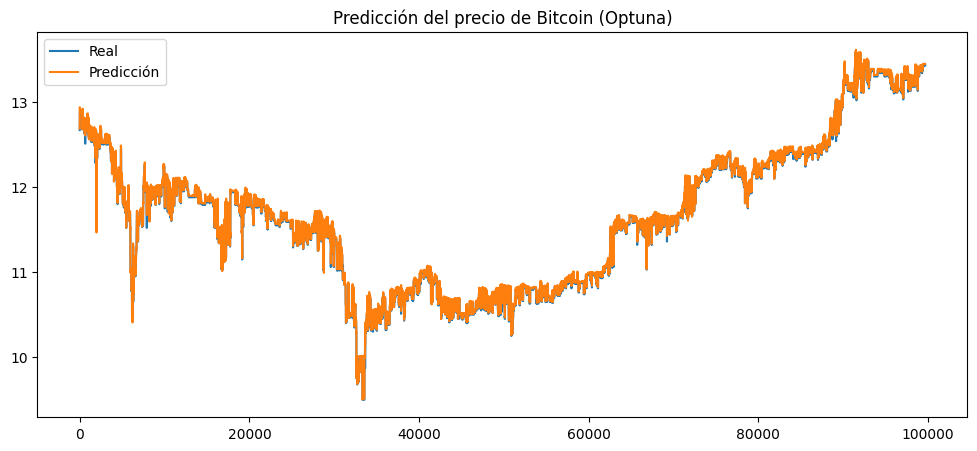

In [ ]:
# Visualización
plt.figure(figsize=(12, 5))
plt.plot(actual, label='Real')
plt.plot(predicted, label='Predicción')
plt.legend()
plt.title("Predicción del precio de Bitcoin (Optuna)")
plt.show()